<a href="https://colab.research.google.com/github/talhawaheed06/Fake-News-Detection-using-ML-and-NLP/blob/main/Fake_News_Detection_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Library Installation

In [ ]:
import pandas as pd
import numpy as np
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Load and Prepare Dataset

In [ ]:
# 1. Load the two separate datasets (Ensure these are uploaded to Colab)
try:
    df_fake = pd.read_csv("Fake.csv")
    df_true = pd.read_csv("True.csv")

    # 2. Add a 'label' column to each
    # 1 = Fake, 0 = Real
    df_fake["label"] = 1
    df_true["label"] = 0

    # 3. Combine them into one dataframe
    # We only need the 'text' column for this project, but we keep title just in case
    df = pd.concat([df_fake, df_true], axis=0)

    # 4. Shuffle the data (important so the model doesn't learn order)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Data loaded successfully!")
    print(f"Total rows: {len(df)}")
    print(df.head())

except FileNotFoundError:
    print("Error: Please upload 'Fake.csv' and 'True.csv' to the Colab file area.")

Data loaded successfully!
Total rows: 44898
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
3         May 22, 2017      1  
4       June 24, 2016       0  


Text Preprocessing Function

In [ ]:
def preprocess_text(text):
    """
    Implements the text preprocessing pipeline:
    1. Lowercasing
    2. Punctuation removal
    3. Tokenization
    4. Stopword removal
    5. Lemmatization
    """
    if not isinstance(text, str):
        return ""

    # 1. Lowercasing
    text = text.lower()

    # 2. Punctuation Removal
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Stopword Removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply the preprocessing (This might take a minute on large datasets)
print("Preprocessing text... this may take a moment.")
df['clean_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")

Preprocessing text... this may take a moment.
Preprocessing complete.


Feature Extraction (TF-IDF)

In [ ]:
# Initialize TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features for speed in Colab

# Create Feature Matrix (X) and Labels (y)
X = tfidf_vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Is vectorizer fitted?", hasattr(tfidf_vectorizer, 'idf_'))
# This MUST print 'True'. If it prints 'False' or errors, your training failed.


print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Is vectorizer fitted? True
Training set shape: (35918, 5000)
Test set shape: (8980, 5000)


Train & Evaluate Logistic Regression (Baseline)

In [ ]:
print("Training Logistic Regression...")
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg_model.predict(X_test)

# Evaluation
print("\n--- Logistic Regression Results ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_log):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_log):.4f}")
print(classification_report(y_test, y_pred_log))

Training Logistic Regression...

--- Logistic Regression Results ---
Accuracy:  0.9832
F1 Score:  0.9839
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4270
           1       0.99      0.98      0.98      4710

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



Train & Evaluate SVM (Comparison)

In [ ]:
print("Training SVM (LinearSVC)...")
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluation
f1_log = f1_score(y_test, y_pred_log)
f1_svm = f1_score(y_test, y_pred_svm)

print("\n--- SVM Results ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score:  {f1_svm:.4f}")
print(classification_report(y_test, y_pred_svm))

# Final Comparison
print("\n--- Final Verdict ---")
if f1_svm > f1_log:
    print(f"SVM performed better (F1: {f1_svm:.4f} vs {f1_log:.4f}). We will save the SVM model.")
    best_model = svm_model
else:
    print(f"Logistic Regression performed better or equal. We will save that.")
    best_model = log_reg_model

Training SVM (LinearSVC)...

--- SVM Results ---
Accuracy:  0.9925
F1 Score:  0.9929
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4270
           1       0.99      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


--- Final Verdict ---
SVM performed better (F1: 0.9929 vs 0.9839). We will save the SVM model.


Save model for deployment

In [ ]:
# Save the model and vectorizer
joblib.dump(best_model, 'fake_news_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("Files saved: 'fake_news_model.pkl' and 'tfidf_vectorizer.pkl'")
print("Download these files from the Colab 'Files' tab on the left to use in your local Streamlit app.")

Files saved: 'fake_news_model.pkl' and 'tfidf_vectorizer.pkl'
Download these files from the Colab 'Files' tab on the left to use in your local Streamlit app.


In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
# Uncomment the line above if you want to save this file in Colab to download it

import streamlit as st
import joblib
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# --- Load Resources ---
model = joblib.load('fake_news_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# --- Preprocessing ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# --- UI ---
st.title("🕵️‍♂️ Fake News Detector")
news_text = st.text_area("News Content", height=200)

if st.button("Check Veracity"):
    if news_text.strip():
        processed_text = preprocess_text(news_text)
        vector_input = vectorizer.transform([processed_text])
        prediction = model.predict(vector_input)[0]

        if prediction == 1:
            st.error("🚨 RESULT: FAKE NEWS DETECTED")
        else:
            st.success("✅ RESULT: REAL NEWS")
    else:
        st.warning("Please enter some text.")

Overwriting app.py


Fake shape: (23481, 4)
Real shape: (21417, 4)
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
Cleaned dataset shape: (44898, 3)
Class distribution:
label
0    23481
1    21417
Name: count,

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 123s 267ms/step - accuracy: 0.8857 - loss: 0.2581 - val_accuracy: 0.9935 - val_loss: 0.0195
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 253ms/step - accuracy: 0.9978 - loss: 0.0083 - val_accuracy: 0.9954 - val_loss: 0.0137
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 117s 260ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9953 - val_loss: 0.0143
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 115s 257ms/step - accuracy: 1.0000 - loss: 1.7279e-04 - val_accuracy: 0.9953 - val_loss: 0.0149
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 1.0000 - loss: 9.8026e-05 - val_accuracy: 0.9953 - val_loss: 0.0150


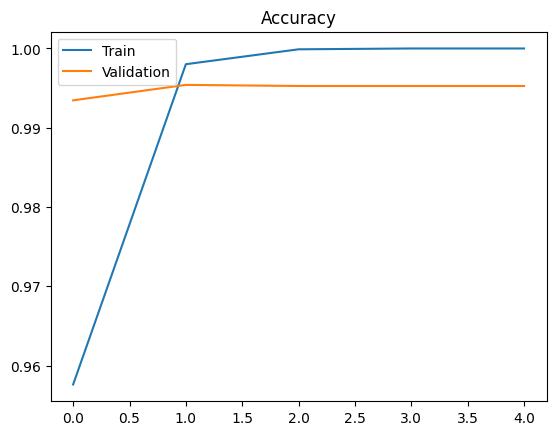

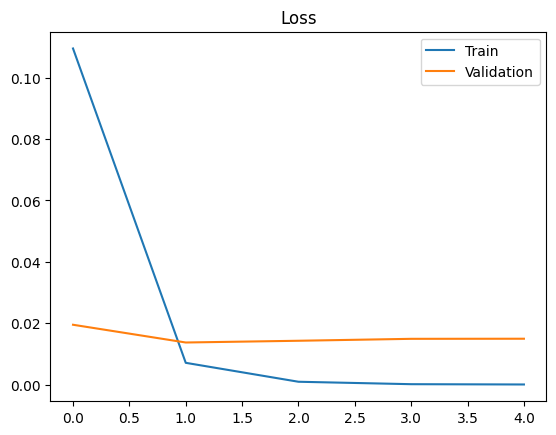

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Accuracy : 0.995879732739421
Precision: 0.9934716717183493
Recall   : 0.9978922716627635
F1-score : 0.995677065077696


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# TASK 1 — LOAD DATASET


df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

print("Fake shape:", df_fake.shape)
print("Real shape:", df_real.shape)
print(df_fake.head())


# TASK 2 — DATA CLEANING

df_fake = df_fake[["title", "text"]]
df_real = df_real[["title", "text"]]

# Add label
df_fake["label"] = "FAKE"
df_real["label"] = "REAL"

# Combine
data = pd.concat([df_fake, df_real]).sample(frac=1, random_state=42)

# Drop missing rows
data = data.dropna()

print("Cleaned dataset shape:", data.shape)


# TASK 3 — LABEL ENCODING


encoder = LabelEncoder()
data["label"] = encoder.fit_transform(data["label"])
# FAKE = 1, REAL = 0

print("Class distribution:")
print(data["label"].value_counts())


# TASK 4 — TEXT PREPARATION


# Use title + text together
data["content"] = data["title"] + " " + data["text"]

X = data["content"].values
y = data["label"].values

max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=max_len, padding="post")


# TASK 5 — TRAIN / TEST SPLIT


X_train, X_test, y_train, y_test = train_test_split(
    padded, y, test_size=0.2, random_state=42
)


# TASK 6 — MODEL ARCHITECTURE (LSTM)


model = Sequential([
    Embedding(max_words, 128, input_length=max_len),

    Conv1D(64, 5, activation="relu"),
    GlobalMaxPooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


# TASK 7 — TRAINING


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

# Plot accuracy
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()
plt.show()


# TASK 8 — EVALUATION


y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
